In [1]:
from google.colab import drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/IRMAI/stock.csv')

In [7]:
data.head()

,Trade_ID,Timestamp,Stock_Symbol,Price,Volume
0,1,2024-02-19 10:00:00,AAPL,150.5,100
1,2,2024-02-19 10:05:00,AAPL,151.0,150
2,3,2024-02-19 10:10:00,MSFT,300.2,200
3,4,2024-02-19 10:15:00,AAPL,152.0,120
4,5,2024-02-19 10:20:00,MSFT,299.8,180


In [8]:
!pip install neo4j pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 6.4 MB/s eta 0:00:00


In [9]:
from neo4j import GraphDatabase

# Get the correct URI from your Neo4j instance
URI = "neo4j+s://acdd2464.databases.neo4j.io"
USERNAME = "neo4j"
PASSWORD = "y9iffGR0ilx6Cv89j2-_bwFSbMJrGARzZ7n-5I4Sljw"

# Connect to Neo4j
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

print("Connected to Neo4j successfully!")


Connected to Neo4j successfully!


In [12]:
# Function to insert trades into Neo4j
def insert_trade(tx, trade_id, symbol, volume, price, timestamp):
    query = """
    CREATE (t:Trade {trade_id: $trade_id, symbol: $symbol, volume: $volume, price: $price, timestamp: $timestamp})
    """
    tx.run(query, trade_id=trade_id, symbol=symbol, volume=volume, price=price, timestamp=timestamp)

# Insert each row into Neo4j
with driver.session() as session:
    for index, row in data.iterrows():
        session.write_transaction(
                                    insert_trade,
                                    row['Trade_ID'],
                                    row['Stock_Symbol'],
                                    row['Volume'],
                                    row['Price'],
                                    row['Timestamp']
                                )


print("Trade data inserted successfully!")

<ipython-input-12-e3b904ef9fa5>:11: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(


Trade data inserted successfully!


In [13]:
def create_consecutive_relationships(tx):
    query = """
    MATCH (t1:Trade), (t2:Trade)
    WHERE t1.timestamp < t2.timestamp
    WITH t1, t2 ORDER BY t1.timestamp, t2.timestamp
    WITH COLLECT(t1) AS trades
    UNWIND RANGE(0, SIZE(trades) - 2) AS i
    WITH trades[i] AS current, trades[i+1] AS next
    MERGE (current)-[:NEXT_TRADE]->(next)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_consecutive_relationships)

print("✅ Consecutive trade relationships created!")




<ipython-input-13-b8e7028dcd2f>:14: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_consecutive_relationships)


✅ Consecutive trade relationships created!


In [14]:
def create_stock_relationships(tx):
    query = """
    MATCH (t1:Trade), (t2:Trade)
    WHERE t1.stock = t2.stock AND t1 <> t2
    MERGE (t1)-[:SAME_STOCK]->(t2)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_stock_relationships)

print("✅ Same stock trade relationships created!")


<ipython-input-14-67fd73542ed1>:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_stock_relationships)


✅ Same stock trade relationships created!


In [15]:
def get_all_trades(tx):
    query = """
    MATCH (t:Trade)
    RETURN t.id AS Trade_ID, t.stock AS Stock_Symbol, t.price AS Price, t.volume AS Volume, t.timestamp AS Timestamp
    ORDER BY t.timestamp
    """
    return tx.run(query).data()

with driver.session() as session:
    trades = session.read_transaction(get_all_trades)

import pandas as pd
df_trades = pd.DataFrame(trades)
print(df_trades)


<ipython-input-15-8062b93ea603>:10: DeprecationWarning: read_transaction has been renamed to execute_read
  trades = session.read_transaction(get_all_trades)


  Trade_ID Stock_Symbol  Price  Volume            Timestamp
0     None         None  150.5     100  2024-02-19 10:00:00
1     None         None  151.0     150  2024-02-19 10:05:00
2     None         None  300.2     200  2024-02-19 10:10:00
3     None         None  152.0     120  2024-02-19 10:15:00
4     None         None  299.8     180  2024-02-19 10:20:00


In [16]:
def get_latest_trade(tx, stock_symbol):
    query = """
    MATCH (t:Trade {stock: $stock_symbol})
    RETURN t.id AS Trade_ID, t.price AS Price, t.volume AS Volume, t.timestamp AS Timestamp
    ORDER BY t.timestamp DESC
    LIMIT 1
    """
    return tx.run(query, stock_symbol=stock_symbol).data()

with driver.session() as session:
    latest_trade = session.read_transaction(get_latest_trade, "AAPL")

print(latest_trade)


<ipython-input-16-c28a9aab24f8>:11: DeprecationWarning: read_transaction has been renamed to execute_read
  latest_trade = session.read_transaction(get_latest_trade, "AAPL")


[]


In [17]:
def get_price_trend(tx, stock_symbol):
    query = """
    MATCH (t:Trade {stock: $stock_symbol})
    RETURN t.timestamp AS Timestamp, t.price AS Price
    ORDER BY t.timestamp
    """
    return tx.run(query, stock_symbol=stock_symbol).data()

with driver.session() as session:
    price_trend = session.read_transaction(get_price_trend, "AAPL")

df_price_trend = pd.DataFrame(price_trend)
print(df_price_trend)


<ipython-input-17-fc70682f1833>:10: DeprecationWarning: read_transaction has been renamed to execute_read
  price_trend = session.read_transaction(get_price_trend, "AAPL")


Empty DataFrame
Columns: []
Index: []


In [20]:
def detect_anomalies(tx, stock_symbol):
    query = """
    MATCH (t:Trade)
    WHERE t.symbol = $stock_symbol
    RETURN t.trade_id AS Trade_ID, t.price AS Price, t.timestamp AS Timestamp
    ORDER BY t.timestamp
    """
    trades = tx.run(query, stock_symbol=stock_symbol).data()

    # Convert to DataFrame
    df = pd.DataFrame(trades)

    # Debugging: Print column names
    print("Columns in DataFrame:", df.columns)

    # Compute mean and standard deviation
    mean_price = df["Price"].mean()
    std_price = df["Price"].std()

    # Compute Z-score
    df["Z_score"] = (df["Price"] - mean_price) / std_price

    # Flag anomalies where |Z_score| > 2.5
    df["Anomaly"] = df["Z_score"].abs() > 2.5

    return df[df["Anomaly"]]  # Return only anomalies

with driver.session() as session:
    anomalies = session.execute_read(detect_anomalies, "AAPL")

print(anomalies)


Columns in DataFrame: Index(['Trade_ID', 'Price', 'Timestamp'], dtype='object')
Empty DataFrame
Columns: [Trade_ID, Price, Timestamp, Z_score, Anomaly]
Index: []


In [19]:
def check_trade_properties(tx):
    query = """
    MATCH (t:Trade)
    RETURN t LIMIT 5
    """
    result = tx.run(query).data()
    return result

with driver.session() as session:
    trades = session.execute_read(check_trade_properties)

print(trades)


[{'t': {'volume': 100, 'symbol': 'AAPL', 'trade_id': 1, 'price': 150.5, 'timestamp': '2024-02-19 10:00:00'}}, {'t': {'volume': 150, 'symbol': 'AAPL', 'trade_id': 2, 'price': 151.0, 'timestamp': '2024-02-19 10:05:00'}}, {'t': {'volume': 200, 'symbol': 'MSFT', 'trade_id': 3, 'price': 300.2, 'timestamp': '2024-02-19 10:10:00'}}, {'t': {'volume': 120, 'symbol': 'AAPL', 'trade_id': 4, 'price': 152.0, 'timestamp': '2024-02-19 10:15:00'}}, {'t': {'volume': 180, 'symbol': 'MSFT', 'trade_id': 5, 'price': 299.8, 'timestamp': '2024-02-19 10:20:00'}}]


In [21]:
!pip install matplotlib


In [22]:
import matplotlib.pyplot as plt


In [34]:
def detect_anomalies(tx, stock_symbol):
    query = """
    MATCH (t:Trade)
    WHERE t.symbol = $stock_symbol
    RETURN t.trade_id AS Trade_ID,
           t.price AS Price,
           t.timestamp AS Timestamp
    ORDER BY t.timestamp
    """
    return list(tx.run(query, stock_symbol=stock_symbol))


In [35]:
with driver.session() as session:
    results = session.execute_read(detect_anomalies, "AAPL")

print("Raw Data from Neo4j:", results)  # This should NOT be empty


Raw Data from Neo4j: [<Record Trade_ID=1 Price=150.5 Timestamp='2024-02-19 10:00:00'>, <Record Trade_ID=2 Price=151.0 Timestamp='2024-02-19 10:05:00'>, <Record Trade_ID=4 Price=152.0 Timestamp='2024-02-19 10:15:00'>]


In [36]:
import pandas as pd

# Convert Neo4j records to a list of dictionaries
data = [dict(record) for record in results]

# Convert to DataFrame
df = pd.DataFrame(data)

print("Converted DataFrame:\n", df.head())  # Debugging step


Converted DataFrame:
    Trade_ID  Price            Timestamp
0         1  150.5  2024-02-19 10:00:00
1         2  151.0  2024-02-19 10:05:00
2         4  152.0  2024-02-19 10:15:00


In [37]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])


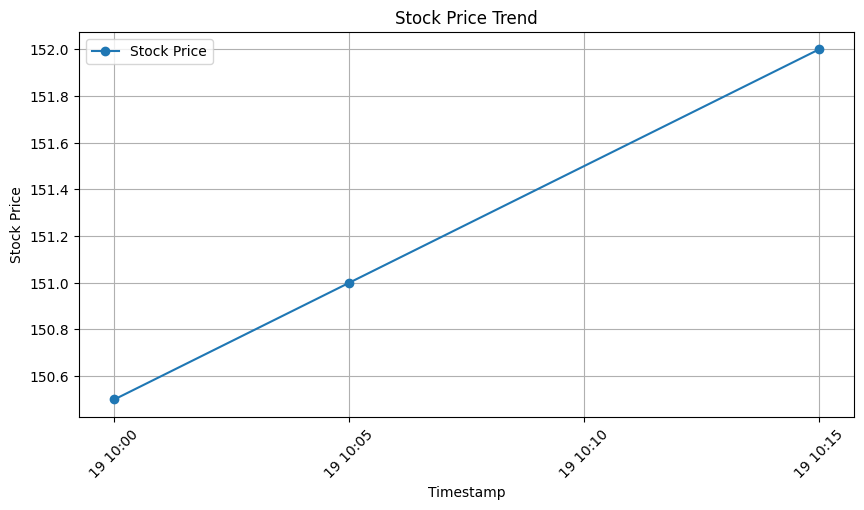

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], df["Price"], marker="o", linestyle="-", label="Stock Price")

plt.xlabel("Timestamp")
plt.ylabel("Stock Price")
plt.title("Stock Price Trend")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
